In [1]:
import findspark
findspark.init()#spark_home="/home/ec2-user/spark"
import pyspark
from pyspark.sql import SparkSession


#get spark session with cluster mode
spark = SparkSession.builder.master("spark://ec2-107-23-177-163.compute-1.amazonaws.com:7077").appName("FYP").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("FYP").getOrCreate()

23/05/10 08:52:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
spark

In [16]:
import pandas as pd

In [ ]:
pd_df = pd.read_csv('./dataset.csv')

spark_df = df_spark = spark.createDataFrame(pd_df)

In [5]:
spark_df

DataFrame[YEAR: bigint, DOY: bigint, T10M: double, CLOUD_AMT: double, QV10M: double, PW: double, PS: double, GLOBAL_ILLUMINANCE: double, WS10M: double, EVLAND: double, latitude: double, longitude: double]

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

In [7]:
input_cols = ['CLOUD_AMT', 'QV10M', 'PW', 'PS', 'GLOBAL_ILLUMINANCE', 'WS10M', 'EVLAND']
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df_assembled = assembler.transform(spark_df)

In [8]:
pca = PCA(k=3, inputCol='features', outputCol='pca_features')
model = pca.fit(df_assembled)
df_pca = model.transform(df_assembled).select('YEAR', 'DOY','T10M','pca_features')

23/05/06 07:53:31 WARN TaskSetManager: Stage 0 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.
23/05/06 07:53:34 WARN TaskSetManager: Stage 1 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.
23/05/06 07:53:38 WARN TaskSetManager: Stage 2 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.
23/05/06 07:53:44 WARN TaskSetManager: Stage 4 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.
23/05/06 07:53:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/05/06 07:53:47 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [9]:
df_pca

DataFrame[YEAR: bigint, DOY: bigint, T10M: double, pca_features: vector]

In [10]:
df_pca.head(5)[0]["pca_features"].values

23/05/06 07:53:47 WARN TaskSetManager: Stage 6 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.


array([ 3.48684183e+04, -9.88316036e+01,  8.61971517e+00])

In [11]:
from pyspark.sql.functions import udf
import numpy as np

In [12]:
df_sampled = df_pca.sample(fraction=0.001, seed=42)
print(f"sampled size={df_sampled.count()}")
print(f"sampled size={df_pca.count()}")

23/05/06 07:53:48 WARN TaskSetManager: Stage 7 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.
23/05/06 07:53:50 WARN TaskSetManager: Stage 9 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.


sampled size=738



[Stage 9:>                                                          (0 + 8) / 8]

sampled size=748750



[Stage 9:============================================>              (6 + 2) / 8]


In [13]:
pca_features_list = [row["pca_features"].values for row in df_sampled.select("pca_features").collect()]

23/05/06 07:53:51 WARN TaskSetManager: Stage 11 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.


In [14]:
import matplotlib.pyplot as plt

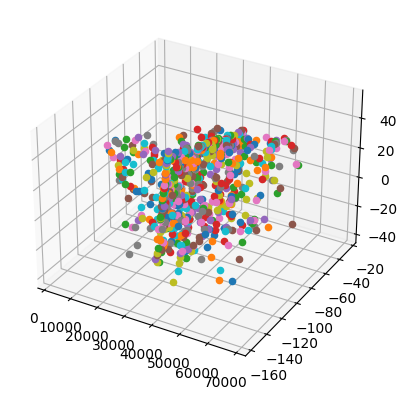

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for point in pca_features_list:
    ax.scatter(point[0], point[1], point[2])

In [16]:
def dense_vector_to_array(v):
    return v.values

In [28]:
pca_features_list

[array([ 3.48684265e+04, -1.03524715e+02, -8.66434149e+00]),
 array([ 3.48684115e+04, -9.44550077e+01,  2.55166575e+01]),
 array([ 3.48684147e+04, -9.62511776e+01,  1.92176654e+01]),
 array([ 3.48684122e+04, -9.45652810e+01,  2.61080120e+01]),
 array([ 3.48684082e+04, -9.24452157e+01,  3.33621724e+01]),
 array([ 3.48684227e+04, -1.01129467e+02,  5.92966874e-01]),
 array([ 3.48684278e+04, -1.04039934e+02, -9.21982728e+00]),
 array([ 3.48684109e+04, -9.41626500e+01,  2.67231197e+01]),
 array([ 3.48684252e+04, -1.02659629e+02, -5.28608569e+00]),
 array([ 3.48684353e+04, -1.08567805e+02, -2.64913996e+01]),
 array([ 3.48684359e+04, -1.08965482e+02, -2.80311146e+01]),
 array([ 3.48684168e+04, -9.76342210e+01,  1.38823490e+01]),
 array([34868.4073589 ,   -91.80473099,    36.21018233]),
 array([ 3.48684223e+04, -1.00761021e+02,  2.34724910e+00]),
 array([ 3.48684260e+04, -1.03331653e+02, -8.36298172e+00]),
 array([ 3.48684099e+04, -9.34895142e+01,  2.95872987e+01]),
 array([34868.40789756,   -

In [38]:
big_dict = [{"PCA1" : row["pca_features"].values[0],"PCA2" : row["pca_features"].values[1], "PCA3" : row["pca_features"].values[2]} for row in df_pca.select("pca_features").collect()]

23/05/06 08:27:32 WARN TaskSetManager: Stage 17 contains a task of very large size (9250 KB). The maximum recommended task size is 100 KB.


In [32]:
big_dict

[{'PCA1': 34868.42654517818,
  'PCA2': -103.52471486880604,
  'PCA3': -8.664341491906981},
 {'PCA1': 34868.41154644665,
  'PCA2': -94.45500771961355,
  'PCA3': 25.51665750794571},
 {'PCA1': 34868.414709141296,
  'PCA2': -96.25117764979747,
  'PCA3': 19.21766544714825},
 {'PCA1': 34868.412166708324,
  'PCA2': -94.56528095758785,
  'PCA3': 26.108012042162805},
 {'PCA1': 34868.40822136829,
  'PCA2': -92.44521570043156,
  'PCA3': 33.362172356489424},
 {'PCA1': 34868.422744496565,
  'PCA2': -101.1294667477029,
  'PCA3': 0.5929668743989538},
 {'PCA1': 34868.42778709552,
  'PCA2': -104.03993405126079,
  'PCA3': -9.219827277754824},
 {'PCA1': 34868.410918873924,
  'PCA2': -94.1626500012683,
  'PCA3': 26.72311972741167},
 {'PCA1': 34868.42515547919,
  'PCA2': -102.65962880061923,
  'PCA3': -5.286085685059234},
 {'PCA1': 34868.43527529699,
  'PCA2': -108.56780495951108,
  'PCA3': -26.491399558619072},
 {'PCA1': 34868.43590865515,
  'PCA2': -108.96548203985186,
  'PCA3': -28.031114595356193},
 {'

In [39]:
PCA_DF = pd.DataFrame.from_dict(big_dict)

In [40]:
final_df = pd.concat([pd_df, PCA_DF], axis=1)

In [41]:
final_df

,YEAR,DOY,T10M,CLOUD_AMT,QV10M,PW,PS,GLOBAL_ILLUMINANCE,WS10M,EVLAND,latitude,longitude,PCA1,PCA2,PCA3
0,1981,1,4.82,61.397109,3.54,2.429962,101.68,34868.508157,13.59,29.29,52.373080,4.892453,34868.418341,-98.831604,8.619715
1,1981,1,8.85,61.397109,4.52,2.429962,100.08,34868.508157,2.06,7.65,37.983941,23.728305,34868.410014,-93.518182,29.145658
2,1981,1,24.87,61.397109,11.47,2.429962,101.05,34868.508157,2.59,27.50,13.752494,100.493509,34868.419052,-98.919951,9.263003
3,1981,1,8.37,61.397109,3.85,2.429962,99.36,34868.508157,3.42,3.94,41.382894,2.177432,34868.408404,-92.558832,32.821408
4,1981,1,-8.01,61.397109,0.67,2.429962,100.05,34868.508157,7.11,3.65,39.906217,116.391276,34868.407691,-92.263940,33.507067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748745,2021,365,2.05,55.700000,3.11,0.480000,100.78,22027.640000,4.70,15.57,35.681266,139.757653,22027.560463,-77.428364,11.347134
748746,2021,365,4.76,85.920000,4.52,1.020000,99.83,11897.230000,2.55,2.66,43.653482,-79.383935,11897.118961,-93.696042,24.218219
748747,2021,365,9.01,50.590000,6.41,1.670000,97.69,13606.560000,4.10,2.24,48.208354,16.372504,13606.487513,-61.298890,16.618035
748748,2021,365,5.70,98.780000,5.68,2.110000,99.59,2815.460000,6.90,-8.18,52.231958,21.006725,2815.336721,-94.708840,31.477372


In [42]:
final_df.to_csv('data_with_pca.csv', index=False)